In [1]:
!pip install gymnasium
!pip install gymnasium[atari]
!pip install gymnasium[accept-rom-license]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 5.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446660 sha256=5cb8ea7529f94beebc66d0991ebe7b7476e93954bf3de831d72cec1ae08de88c
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license


In [62]:
import gymnasium as gym
import sys
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Convolution2D, Flatten
from keras.optimizers import Adam
from collections import deque
import time

np.set_printoptions(threshold=sys.maxsize)


class DQNAgent:
    def __init__(self, actions, states, epsilon,epsilon_decay,epsilon_min,gamma,model=None):
        self.actions = actions
        self.states = states
        self.memory = deque(maxlen=50000)
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.gamma = gamma
        if model is None:
          self.model = self.build_model()
        else:
          self.model = model


    def build_model(self):
        model = Sequential()
        model.add(Convolution2D(32, (8,8), strides=(4,4), activation='relu', input_shape=(self.states)))
        model.add(Convolution2D(64, (4,4), strides=(2,2), activation='relu'))
        model.add(Convolution2D(64, (3,3), activation='relu'))
        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
        model.add(Dense(256, activation='relu'))
        model.add(Dense(self.actions, activation='linear'))
        model.compile(optimizer=Adam(learning_rate=0.0003), loss='mse')
        return model

    def buffer(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

# Exploration-exploitation strategy to choose an action based on epsilon-greedy
    def learn_action(self, state):
        if random.uniform(0,1) <= self.epsilon:
            return np.random.choice(self.actions)

        else:
            value = self.model.predict(state,verbose=0)
            return np.argmax(value[0]) # highest Q-value

# Learning from a minibatch of using the Q-learning
    def learn_model(self, batch_size=128):
        minibatch = random.sample(self.memory, min(batch_size, len(self.memory)))

        states = []
        target_fs = []

        for state, action, reward, next_state, done in minibatch:
            target = reward

            if not done:
                target += self.gamma * np.amax(self.model.predict(next_state.reshape(4, *self.states),verbose=0))

            target_f = self.model.predict(state.reshape(4, *self.states),verbose=0)
            target_f[0][action] = target
            states.append(state)
            target_fs.append(target_f)

        states = np.array(states)
        target_fs = np.array(target_fs)
        # print()
        # history = self.model.fit(x=states, y=target_fs, epochs=1, verbose=0)
        # # print()Z
        # loss = history.history['loss'][0]
        #print(f"Loss: {loss}")

    def update_epsilon(self):
        print(f"Old = Epsilon: {self.epsilon}")
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)
        print(f"New = Epsilon: {self.epsilon}")



def preprocess_frame_grayscale(obs):

    r, g, b = obs[:,:,0],obs[:,:,1],obs[:,:,2]
    grayscale = 0.2989 * r + 0.5870 * g + 0.1140 * b

    grayscale /= 255
    return grayscale

def preprocess_frame_downscale(obs):

    r, g, b = obs[:,:,0],obs[:,:,1],obs[:,:,2]
    grayscale = 0.2989 * r + 0.5870 * g + 0.1140 * b
    grayscale = grayscale.reshape(1,210,160,1)
    grayscale /= 255

    grayscale = tf.image.resize(grayscale,[105,80])[0,...,0].numpy()
    # print(grayscale.shape)
    return grayscale

def preprocess_frame_normalize(obs):

    # r, g, b = obs[:,:,0],obs[:,:,1],obs[:,:,2]
    # grayscale = 0.2989 * r + 0.5870 * g + 0.1140 * b

    # grayscale /= 255
    return obs/255

def stack_frames(stacked_frames,state,is_new):
  frame = preprocess_frame_downscale(state)

  if is_new:
    stacked_frames = deque([np.zeros((105,80,1),dtype=np.int) for i in range(len(stacked_frames))],maxlen=4)

    for i in range(4):
      stacked_frames.append(frame)
    stacked_state = np.stack(stacked_frames,axis=0)

  else:
    stacked_frames.append(frame)
    stacked_state = np.stack(stacked_frames,axis=0)
  # print(stacked_state.shape)
  return stacked_state,stacked_frames

def run(epochs=10, batch_size=32,epsilon=0,epsilon_decay=0,epsilon_min=0,gamma=0):
    env = gym.make("ALE/SpaceInvaders-v5", render_mode="rgb_array",mode=0,difficulty=0)
    # print(env.observation_space.shape)
    # with sess:
    agent = DQNAgent( env.action_space.n, (105,80,1),epsilon,epsilon_decay,epsilon_min,gamma)
    observation, info = env.reset()
    total_rewards = []
    frames = 0
    for epoch in range(epochs):
        score = 0
        observation = preprocess_frame_downscale(observation)
        for it in range(1000):
            frames += 1
            # action = agent.learn_action(observation)
            action = agent.learn_action(observation.reshape(1,105,80,1))
            next_observation, reward, terminated, _, _ = env.step(action)
            next_observation = preprocess_frame_downscale(next_observation)

            agent.buffer(observation, action, reward, next_observation, terminated)
            # model_inputs = {'lives':0, 'game_state':observation, 'score':score, 'reward':reward }
            # lives = 0
            if reward > 0:
                score += reward
                # print(f"====================")
                # print(f"reward: {reward}")
                # print(f"score: {score}")
                # print(f"Iterations: {it}")
            if terminated:
                agent.learn_model()
                break
            observation = next_observation


        agent.update_epsilon()
        total_rewards.append(score)

        print(f"Epoch {epoch + 1}, Total Reward: {score}, Total Frames so far: {frames}")

        observation, info = env.reset()

    plt.plot(range(1, epochs + 1), total_rewards, marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Total Reward')
    plt.title('Total Reward per Epoch')
    plt.show()

    env.close()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Old = Epsilon: 0.99
New = Epsilon: 0.9405
Epoch 1, Total Reward: 65.0, Total Frames so far: 379


<ipython-input-2-2dd47baf2afb>:119: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  stacked_frames = deque([np.zeros((105,80,1),dtype=np.int) for i in range(len(stacked_frames))],maxlen=4)


Old = Epsilon: 0.9405
New = Epsilon: 0.8934749999999999
Epoch 2, Total Reward: 440.0, Total Frames so far: 1530
Old = Epsilon: 0.8934749999999999
New = Epsilon: 0.8488012499999998
Epoch 3, Total Reward: 75.0, Total Frames so far: 1972
Old = Epsilon: 0.8488012499999998
New = Epsilon: 0.8063611874999999
Epoch 4, Total Reward: 270.0, Total Frames so far: 2734
Old = Epsilon: 0.8063611874999999
New = Epsilon: 0.7660431281249999
Epoch 5, Total Reward: 40.0, Total Frames so far: 3215
Old = Epsilon: 0.7660431281249999
New = Epsilon: 0.7277409717187499
Epoch 6, Total Reward: 55.0, Total Frames so far: 3682
Old = Epsilon: 0.7277409717187499
New = Epsilon: 0.6913539231328123
Epoch 7, Total Reward: 80.0, Total Frames so far: 4063
Old = Epsilon: 0.6913539231328123
New = Epsilon: 0.6567862269761716
Epoch 8, Total Reward: 90.0, Total Frames so far: 4761
Old = Epsilon: 0.6567862269761716
New = Epsilon: 0.623946915627363
Epoch 9, Total Reward: 85.0, Total Frames so far: 5155
Old = Epsilon: 0.6239469156

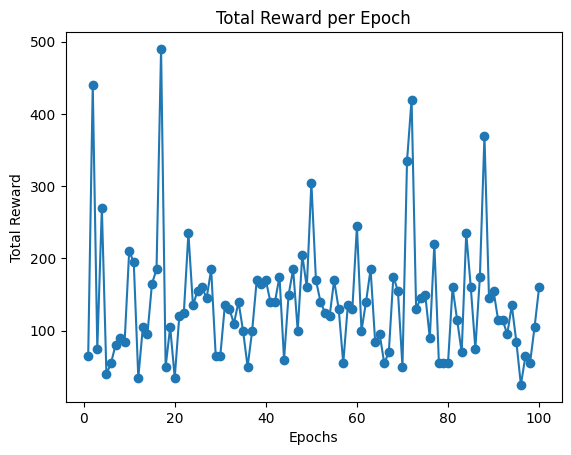

In [3]:


epsilon = 0.99
epsilon_decay = 0.95
epsilon_min = 0.20
gamma = 0.05
epochs = 100
env = gym.make("ALE/SpaceInvaders-v5", render_mode="rgb_array",mode=0,difficulty=0)
agent = DQNAgent( env.action_space.n, (105,80,1),epsilon,epsilon_decay,epsilon_min,gamma)

checkpoint = tf.train.Checkpoint(model=agent.model)
manager = tf.train.CheckpointManager(
    checkpoint, directory="/tmp/model",max_to_keep=5)
status = checkpoint.restore(manager.latest_checkpoint)

observation, info = env.reset()

total_rewards1 = []
stacked_frames = []
frames = 0
for epoch in range(epochs):
    score = 0
    # observation = preprocess_frame_downscale(observation)
    observation,stacked_frames = stack_frames(stacked_frames,observation,True)

    for it in range(5000):
        frames += 1
        # action = agent.learn_action(observation)
        action = agent.learn_action(observation.reshape(4,105,80,1))

        next_observation, reward, terminated, _, _ = env.step(action)
        next_observation, stacked_frames = stack_frames(stacked_frames,next_observation,False)
        # next_observation = preprocess_frame_downscale(next_observation)

        agent.buffer(observation, action, reward, next_observation, terminated)
        if reward > 0:
            score += reward
            # print(f"====================")
            # print(f"reward: {reward} | score: {score} | Iterations: {it}")
        if terminated:
            agent.learn_model()
            break
        observation = next_observation
    agent.update_epsilon()
    total_rewards1.append(score)

    print(f"Epoch {epoch + 1}, Total Reward: {score}, Total Frames so far: {frames}")

    observation, info = env.reset()

    manager.save()

plt.plot(range(1, epochs + 1), total_rewards1, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Total Reward')
plt.title('Total Reward per Epoch')
plt.show()

env.close()

In [4]:
checkpoint.restore(manager.latest_checkpoint)
model = agent.model

env = gym.make("ALE/SpaceInvaders-v5", render_mode="rgb_array",mode=0,difficulty=0)
agent = DQNAgent( env.action_space.n, (105,80,1),epsilon,epsilon_decay,epsilon_min,gamma)

observation, info = env.reset()
total_rewards2 = []
frames = 0

for epoch in range(10):
    score = 0
    observation = preprocess_frame_downscale(observation)
    for it in range(100_000):
        frames += 1
        # action = agent.learn_action(observation)
        action = np.argmax(model.predict(observation.reshape(1,105,80,1),verbose=0)[0]) # highest Q-value
        # action = agent.learn_action(observation.reshape(1,105,80,1))
        next_observation, reward, terminated, _, _ = env.step(action)
        next_observation = preprocess_frame_downscale(next_observation)

        agent.buffer(observation, action, reward, next_observation, terminated)
        if reward > 0:
            score += reward
            print(f"Total Score: {score}, Total Frames: {frames}")
        if terminated:
            # agent.learn_model()
            break
        observation = next_observation
    # agent.update_epsilon()
    total_rewards2.append(score)

    print(f"Epoch {epoch + 1}, Total Reward: {score}, Total Frames so far: {frames}")

    observation, info = env.reset()
env.close()
print(f"Average score of 10 random games: {np.mean(total_rewards2)}")


Total Score: 5.0, Total Frames: 174
Total Score: 10.0, Total Frames: 181
Total Score: 15.0, Total Frames: 190
Epoch 1, Total Reward: 15.0, Total Frames so far: 689
Total Score: 5.0, Total Frames: 863
Total Score: 10.0, Total Frames: 870
Total Score: 15.0, Total Frames: 879
Epoch 2, Total Reward: 15.0, Total Frames so far: 1380
Total Score: 5.0, Total Frames: 1555
Total Score: 10.0, Total Frames: 1562
Epoch 3, Total Reward: 10.0, Total Frames so far: 1997
Total Score: 5.0, Total Frames: 2171
Total Score: 10.0, Total Frames: 2178
Epoch 4, Total Reward: 10.0, Total Frames so far: 2502
Total Score: 5.0, Total Frames: 2676
Total Score: 10.0, Total Frames: 2683
Total Score: 15.0, Total Frames: 2691
Epoch 5, Total Reward: 15.0, Total Frames so far: 3181
Total Score: 5.0, Total Frames: 3355
Total Score: 10.0, Total Frames: 3362
Total Score: 15.0, Total Frames: 3370
Epoch 6, Total Reward: 15.0, Total Frames so far: 3860
Total Score: 5.0, Total Frames: 4035
Total Score: 10.0, Total Frames: 4042


In [5]:
checkpoint.restore(manager.latest_checkpoint)
model = agent.model

env = gym.make("ALE/SpaceInvaders-v5", render_mode="rgb_array",mode=0,difficulty=0)
agent = DQNAgent( env.action_space.n, (105,80,1),epsilon,epsilon_decay,epsilon_min,gamma)

observation, info = env.reset()
total_rewards3 = []
frames = 0

for epoch in range(100):
    score = 0
    observation = preprocess_frame_downscale(observation)
    for it in range(100_000):
        frames += 1
        # action = agent.learn_action(observation)
        action = np.random.randint(0,6) # highest Q-value
        # action = agent.learn_action(observation.reshape(1,105,80,1))
        next_observation, reward, terminated, _, _ = env.step(action)
        next_observation = preprocess_frame_downscale(next_observation)

        agent.buffer(observation, action, reward, next_observation, terminated)
        if reward > 0:
            score += reward
            print(f"Total Score: {score}, Total Frames: {frames}")
        if terminated:
            # agent.learn_model()
            break
        observation = next_observation
    # agent.update_epsilon()
    total_rewards3.append(score)

    print(f"Epoch {epoch + 1}, Total Reward: {score}, Total Frames so far: {frames}")

    observation, info = env.reset()
env.close()
print(f"Average score of 100 random games: {np.mean(total_rewards3)}")


Total Score: 5.0, Total Frames: 169
Total Score: 15.0, Total Frames: 183
Total Score: 30.0, Total Frames: 227
Total Score: 50.0, Total Frames: 262
Total Score: 75.0, Total Frames: 397
Total Score: 105.0, Total Frames: 413
Total Score: 110.0, Total Frames: 440
Total Score: 120.0, Total Frames: 449
Total Score: 135.0, Total Frames: 465
Epoch 1, Total Reward: 135.0, Total Frames so far: 491
Total Score: 5.0, Total Frames: 610
Total Score: 10.0, Total Frames: 663
Total Score: 20.0, Total Frames: 689
Epoch 2, Total Reward: 20.0, Total Frames so far: 858
Total Score: 5.0, Total Frames: 898
Total Score: 20.0, Total Frames: 955
Total Score: 25.0, Total Frames: 968
Total Score: 50.0, Total Frames: 987
Total Score: 60.0, Total Frames: 998
Total Score: 80.0, Total Frames: 1061
Total Score: 110.0, Total Frames: 1080
Total Score: 120.0, Total Frames: 1222
Total Score: 135.0, Total Frames: 1232
Total Score: 155.0, Total Frames: 1244
Epoch 3, Total Reward: 155.0, Total Frames so far: 1269
Total Score

# Non frame stacking test


In [6]:
import gymnasium as gym
import sys
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Convolution2D, Flatten
from keras.optimizers import Adam
from collections import deque
import time

np.set_printoptions(threshold=sys.maxsize)


class DQNAgent:
    def __init__(self, actions, states, epsilon,epsilon_decay,epsilon_min,gamma,model=None):
        self.actions = actions
        self.states = states
        self.memory = deque(maxlen=50000)
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.gamma = gamma
        if model is None:
          self.model = self.build_model()
        else:
          self.model = model


    def build_model(self):
        model = Sequential()
        model.add(Convolution2D(32, (8,8), strides=(4,4), activation='relu', input_shape=(self.states)))
        model.add(Convolution2D(64, (4,4), strides=(2,2), activation='relu'))
        model.add(Convolution2D(64, (3,3), activation='relu'))
        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
        model.add(Dense(256, activation='relu'))
        model.add(Dense(self.actions, activation='linear'))
        model.compile(optimizer=Adam(learning_rate=0.0003), loss='mse')
        return model

    def buffer(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

# Exploration-exploitation strategy to choose an action based on epsilon-greedy
    def learn_action(self, state):
        if random.uniform(0,1) <= self.epsilon:
            return np.random.choice(self.actions)

        else:
            value = self.model.predict(state,verbose=0)
            return np.argmax(value[0]) # highest Q-value

# Learning from a minibatch of using the Q-learning
    def learn_model(self, batch_size=128):
        minibatch = random.sample(self.memory, min(batch_size, len(self.memory)))

        states = []
        target_fs = []

        for state, action, reward, next_state, done in minibatch:
            target = reward

            if not done:
                target += self.gamma * np.amax(self.model.predict(next_state.reshape(1, *self.states),verbose=0))

            target_f = self.model.predict(state.reshape(1, *self.states),verbose=0)
            target_f[0][action] = target
            states.append(state)
            target_fs.append(target_f)

        states = np.array(states)
        target_fs = np.array(target_fs)
        # print()
        history = self.model.fit(x=states, y=target_fs, epochs=1, verbose=0)
        # print()Z
        loss = history.history['loss'][0]
        #print(f"Loss: {loss}")

    def update_epsilon(self):
        # print(f"Old = Epsilon: {self.epsilon}")
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)
        # print(f"New = Epsilon: {self.epsilon}")



def preprocess_frame_grayscale(obs):

    r, g, b = obs[:,:,0],obs[:,:,1],obs[:,:,2]
    grayscale = 0.2989 * r + 0.5870 * g + 0.1140 * b

    grayscale /= 255
    return grayscale

def preprocess_frame_downscale(obs):

    r, g, b = obs[:,:,0],obs[:,:,1],obs[:,:,2]
    grayscale = 0.2989 * r + 0.5870 * g + 0.1140 * b
    grayscale = grayscale.reshape(1,210,160,1)
    grayscale /= 255

    grayscale = tf.image.resize(grayscale,[105,80])[0,...,0].numpy()
    # print(grayscale.shape)
    return grayscale

def preprocess_frame_normalize(obs):

    # r, g, b = obs[:,:,0],obs[:,:,1],obs[:,:,2]
    # grayscale = 0.2989 * r + 0.5870 * g + 0.1140 * b

    # grayscale /= 255
    return obs/255

def stack_frames(stacked_frames,state,is_new):
  frame = preprocess_frame_downscale(state)

  if is_new:
    stacked_frames = deque([np.zeros((105,80,1),dtype=np.int) for i in range(len(stacked_frames))],maxlen=4)

    for i in range(4):
      stacked_frames.append(frame)
    stacked_state = np.stack(stacked_frames,axis=0)

  else:
    stacked_frames.append(frame)
    stacked_state = np.stack(stacked_frames,axis=0)
  # print(stacked_state.shape)
  return stacked_state,stacked_frames

def run(epochs=10, batch_size=32,epsilon=0,epsilon_decay=0,epsilon_min=0,gamma=0):
    env = gym.make("ALE/SpaceInvaders-v5", render_mode="rgb_array",mode=0,difficulty=0)
    # print(env.observation_space.shape)
    # with sess:
    agent = DQNAgent( env.action_space.n, (105,80,1),epsilon,epsilon_decay,epsilon_min,gamma)
    observation, info = env.reset()
    total_rewards = []
    frames = 0
    for epoch in range(epochs):
        score = 0
        observation = preprocess_frame_downscale(observation)
        for it in range(1000):
            frames += 1
            # action = agent.learn_action(observation)
            action = agent.learn_action(observation.reshape(1,105,80,1))
            next_observation, reward, terminated, _, _ = env.step(action)
            next_observation = preprocess_frame_downscale(next_observation)

            agent.buffer(observation, action, reward, next_observation, terminated)
            # model_inputs = {'lives':0, 'game_state':observation, 'score':score, 'reward':reward }
            # lives = 0
            if reward > 0:
                score += reward
                # print(f"====================")
                # print(f"reward: {reward}")
                # print(f"score: {score}")
                # print(f"Iterations: {it}")
            if terminated:
                agent.learn_model()
                break
            observation = next_observation


        agent.update_epsilon()
        total_rewards.append(score)

        print(f"Epoch {epoch + 1}, Total Reward: {score}, Total Frames so far: {frames}")

        observation, info = env.reset()

    plt.plot(range(1, epochs + 1), total_rewards, marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Total Reward')
    plt.title('Total Reward per Epoch')
    plt.show()

    env.close()



#########################




Epoch 1, Total Reward: 100.0, Total Frames so far: 525
Epoch 2, Total Reward: 225.0, Total Frames so far: 1236
Epoch 3, Total Reward: 210.0, Total Frames so far: 1971
Epoch 4, Total Reward: 345.0, Total Frames so far: 2558
Epoch 5, Total Reward: 50.0, Total Frames so far: 2845
Epoch 6, Total Reward: 210.0, Total Frames so far: 3441
Epoch 7, Total Reward: 120.0, Total Frames so far: 4032
Epoch 8, Total Reward: 180.0, Total Frames so far: 4661
Epoch 9, Total Reward: 210.0, Total Frames so far: 5297
Epoch 10, Total Reward: 155.0, Total Frames so far: 5893
Epoch 11, Total Reward: 155.0, Total Frames so far: 6485
Epoch 12, Total Reward: 530.0, Total Frames so far: 7493
Epoch 13, Total Reward: 135.0, Total Frames so far: 8091
Epoch 14, Total Reward: 105.0, Total Frames so far: 8578
Epoch 15, Total Reward: 155.0, Total Frames so far: 9173
Epoch 16, Total Reward: 355.0, Total Frames so far: 9770
Epoch 17, Total Reward: 210.0, Total Frames so far: 10408
Epoch 18, Total Reward: 525.0, Total Fram

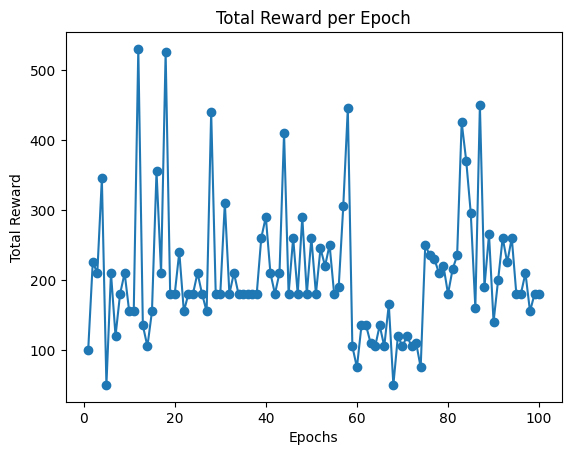

In [7]:
epsilon = 0.99
epsilon_decay = 0.95
epsilon_min = 0.2
gamma = 0.05
epochs = 100
env = gym.make("ALE/SpaceInvaders-v5", render_mode="rgb_array",mode=0,difficulty=0)
agent = DQNAgent( env.action_space.n, (105,80,1),epsilon,epsilon_decay,epsilon_min,gamma)

checkpoint = tf.train.Checkpoint(model=agent.model)
manager = tf.train.CheckpointManager(
    checkpoint, directory="/tmp/model",max_to_keep=5)
status = checkpoint.restore(manager.latest_checkpoint)

observation, info = env.reset()
total_rewards4 = []
frames = 0
for epoch in range(epochs):
    score = 0
    observation = preprocess_frame_downscale(observation)
    for it in range(5000):
        frames += 1
        # action = agent.learn_action(observation)
        action = agent.learn_action(observation.reshape(1,105,80,1))
        next_observation, reward, terminated, _, _ = env.step(action)
        next_observation = preprocess_frame_downscale(next_observation)

        agent.buffer(observation, action, reward, next_observation, terminated)
        if reward > 0:
            score += reward
        if terminated:
            agent.learn_model()
            break
        observation = next_observation
    agent.update_epsilon()
    total_rewards4.append(score)

    print(f"Epoch {epoch + 1}, Total Reward: {score}, Total Frames so far: {frames}")

    observation, info = env.reset()

    manager.save()

plt.plot(range(1, epochs + 1), total_rewards4, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Total Reward')
plt.title('Total Reward per Epoch')
plt.show()

env.close()


In [ ]:


epsilon = 0.99
epsilon_decay = 0.95
epsilon_min = 0.20
gamma = 0.05
epochs = 100
env = gym.make("ALE/SpaceInvaders-v5", render_mode="rgb_array",mode=0,difficulty=0)
agent = DQNAgent( env.action_space.n, (105,80,1),epsilon,epsilon_decay,epsilon_min,gamma)

checkpoint = tf.train.Checkpoint(model=agent.model)
manager = tf.train.CheckpointManager(
    checkpoint, directory="/tmp/model",max_to_keep=5)
status = checkpoint.restore(manager.latest_checkpoint)

observation, info = env.reset()

total_rewards1 = []
stacked_frames = []
frames = 0
for epoch in range(epochs):
    score = 0
    # observation = preprocess_frame_downscale(observation)
    observation,stacked_frames = stack_frames(stacked_frames,observation,True)

    for it in range(5000):
        frames += 1
        # action = agent.learn_action(observation)
        action = agent.learn_action(observation.reshape(4,105,80,1))

        next_observation, reward, terminated, _, _ = env.step(action)
        next_observation, stacked_frames = stack_frames(stacked_frames,next_observation,False)
        # next_observation = preprocess_frame_downscale(next_observation)

        agent.buffer(observation, action, reward, next_observation, terminated)
        if reward > 0:
            score += reward
            # print(f"====================")
            # print(f"reward: {reward} | score: {score} | Iterations: {it}")
        if terminated:
            agent.learn_model()
            break
        observation = next_observation
    agent.update_epsilon()
    total_rewards1.append(score)

    print(f"Epoch {epoch + 1}, Total Reward: {score}, Total Frames so far: {frames}")

    observation, info = env.reset()

    manager.save()

plt.plot(range(1, epochs + 1), total_rewards1, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Total Reward')
plt.title('Total Reward per Epoch')
plt.show()

env.close()

Old = Epsilon: 0.99
New = Epsilon: 0.9405
Epoch 1, Total Reward: 65.0, Total Frames so far: 301


<ipython-input-62-2dd47baf2afb>:119: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  stacked_frames = deque([np.zeros((105,80,1),dtype=np.int) for i in range(len(stacked_frames))],maxlen=4)


Old = Epsilon: 0.9405
New = Epsilon: 0.8934749999999999
Epoch 2, Total Reward: 90.0, Total Frames so far: 751
Old = Epsilon: 0.8934749999999999
New = Epsilon: 0.8488012499999998
Epoch 3, Total Reward: 135.0, Total Frames so far: 1237


Old = Epsilon: 0.8488012499999998
New = Epsilon: 0.8063611874999999
Epoch 4, Total Reward: 155.0, Total Frames so far: 1841
Old = Epsilon: 0.8063611874999999
New = Epsilon: 0.7660431281249999
Epoch 5, Total Reward: 335.0, Total Frames so far: 2415
Old = Epsilon: 0.7660431281249999
New = Epsilon: 0.7277409717187499
Epoch 6, Total Reward: 155.0, Total Frames so far: 3028
Old = Epsilon: 0.7277409717187499
New = Epsilon: 0.6913539231328123
Epoch 7, Total Reward: 105.0, Total Frames so far: 3343
Old = Epsilon: 0.6913539231328123
New = Epsilon: 0.6567862269761716
Epoch 8, Total Reward: 105.0, Total Frames so far: 3830
Old = Epsilon: 0.6567862269761716
New = Epsilon: 0.623946915627363
Epoch 9, Total Reward: 105.0, Total Frames so far: 4333
Old = Epsilon: 0.623946915627363
New = Epsilon: 0.5927495698459949
Epoch 10, Total Reward: 155.0, Total Frames so far: 4942
Old = Epsilon: 0.5927495698459949
New = Epsilon: 0.5631120913536951
Epoch 11, Total Reward: 260.0, Total Frames so far: 5684
Old = Ep

In [8]:
checkpoint.restore(manager.latest_checkpoint)
model = agent.model

env = gym.make("ALE/SpaceInvaders-v5", render_mode="rgb_array",mode=0,difficulty=0)
agent = DQNAgent( env.action_space.n, (105,80,1),epsilon,epsilon_decay,epsilon_min,gamma)

observation, info = env.reset()
total_rewards5 = []
frames = 0

for epoch in range(10):
    score = 0
    observation = preprocess_frame_downscale(observation)
    for it in range(100_000):
        frames += 1
        # action = agent.learn_action(observation)
        action = np.argmax(model.predict(observation.reshape(1,105,80,1),verbose=0)[0]) # highest Q-value
        # action = agent.learn_action(observation.reshape(1,105,80,1))
        next_observation, reward, terminated, _, _ = env.step(action)
        next_observation = preprocess_frame_downscale(next_observation)

        agent.buffer(observation, action, reward, next_observation, terminated)
        if reward > 0:
            score += reward
            print(f"Total Score: {score}, Total Frames: {frames}")
        if terminated:
            # agent.learn_model()
            break
        observation = next_observation
    # agent.update_epsilon()
    total_rewards5.append(score)

    print(f"Epoch {epoch + 1}, Total Reward: {score}, Total Frames so far: {frames}")

    observation, info = env.reset()
env.close()
print(f"Average score of 10 random games: {np.mean(total_rewards5)}")


Total Score: 5.0, Total Frames: 102
Total Score: 15.0, Total Frames: 110
Total Score: 30.0, Total Frames: 122
Total Score: 50.0, Total Frames: 135
Total Score: 75.0, Total Frames: 151
Total Score: 105.0, Total Frames: 168
Total Score: 110.0, Total Frames: 503
Total Score: 120.0, Total Frames: 511
Total Score: 135.0, Total Frames: 521
Total Score: 155.0, Total Frames: 533
Total Score: 180.0, Total Frames: 547
Total Score: 210.0, Total Frames: 564
Total Score: 225.0, Total Frames: 669
Total Score: 230.0, Total Frames: 674
Total Score: 240.0, Total Frames: 681
Total Score: 260.0, Total Frames: 693
Total Score: 285.0, Total Frames: 707
Epoch 1, Total Reward: 285.0, Total Frames so far: 726
Total Score: 5.0, Total Frames: 828
Total Score: 15.0, Total Frames: 836
Total Score: 30.0, Total Frames: 848
Total Score: 50.0, Total Frames: 861
Total Score: 75.0, Total Frames: 877
Total Score: 105.0, Total Frames: 894
Total Score: 110.0, Total Frames: 1229
Total Score: 120.0, Total Frames: 1237
Total

In [11]:
print(total_rewards4)

[100.0, 225.0, 210.0, 345.0, 50.0, 210.0, 120.0, 180.0, 210.0, 155.0, 155.0, 530.0, 135.0, 105.0, 155.0, 355.0, 210.0, 525.0, 180.0, 180.0, 240.0, 155.0, 180.0, 180.0, 210.0, 180.0, 155.0, 440.0, 180.0, 180.0, 310.0, 180.0, 210.0, 180.0, 180.0, 180.0, 180.0, 180.0, 260.0, 290.0, 210.0, 180.0, 210.0, 410.0, 180.0, 260.0, 180.0, 290.0, 180.0, 260.0, 180.0, 245.0, 220.0, 250.0, 180.0, 190.0, 305.0, 445.0, 105.0, 75.0, 135.0, 135.0, 110.0, 105.0, 135.0, 105.0, 165.0, 50.0, 120.0, 105.0, 120.0, 105.0, 110.0, 75.0, 250.0, 235.0, 230.0, 210.0, 220.0, 180.0, 215.0, 235.0, 425.0, 370.0, 295.0, 160.0, 450.0, 190.0, 265.0, 140.0, 200.0, 260.0, 225.0, 260.0, 180.0, 180.0, 210.0, 155.0, 180.0, 180.0]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
oh_oh_5 = [100.0, 225.0, 210.0, 345.0, 50.0, 210.0, 120.0, 180.0, 210.0, 155.0, 155.0, 530.0, 135.0, 105.0, 155.0, 355.0, 210.0, 525.0, 180.0, 180.0, 240.0, 155.0, 180.0, 180.0, 210.0, 180.0, 155.0, 440.0, 180.0, 180.0, 310.0, 180.0, 210.0, 180.0, 180.0, 180.0, 180.0, 180.0, 260.0, 290.0, 210.0, 180.0, 210.0, 410.0, 180.0, 260.0, 180.0, 290.0, 180.0, 260.0, 180.0, 245.0, 220.0, 250.0, 180.0, 190.0, 305.0, 445.0, 105.0, 75.0, 135.0, 135.0, 110.0, 105.0, 135.0, 105.0, 165.0, 50.0, 120.0, 105.0, 120.0, 105.0, 110.0, 75.0, 250.0, 235.0, 230.0, 210.0, 220.0, 180.0, 215.0, 235.0, 425.0, 370.0, 295.0, 160.0, 450.0, 190.0, 265.0, 140.0, 200.0, 260.0, 225.0, 260.0, 180.0, 180.0, 210.0, 155.0, 180.0, 180.0]
oh_1 = [65.0, 110.0, 210.0, 130.0, 120.0, 410.0, 105.0, 120.0, 105.0, 350.0, 180.0, 135.0, 315.0, 105.0, 210.0, 135.0, 180.0, 135.0, 80.0, 75.0, 180.0, 155.0, 380.0, 155.0, 120.0, 155.0, 240.0, 120.0, 210.0, 210.0, 410.0, 50.0, 75.0, 420.0, 210.0, 210.0, 120.0, 135.0, 155.0, 120.0, 285.0, 210.0, 210.0, 50.0, 125.0, 260.0, 225.0, 50.0, 210.0, 105.0, 180.0, 125.0, 520.0, 210.0, 210.0, 155.0, 210.0, 225.0, 250.0, 120.0, 105.0, 335.0, 485.0, 515.0, 510.0, 210.0, 210.0, 260.0, 50.0, 210.0, 215.0, 120.0, 210.0, 180.0, 155.0, 155.0, 355.0, 340.0, 180.0, 685.0, 225.0, 455.0, 155.0, 155.0, 410.0, 80.0, 30.0, 210.0, 260.0, 215.0, 195.0, 500.0, 50.0, 210.0, 105.0, 200.0, 155.0, 210.0, 60.0, 160.0]
oh_2 = [365.0, 45.0, 30.0, 210.0, 350.0, 215.0, 345.0, 135.0, 30.0, 155.0, 135.0, 155.0, 135.0, 105.0, 385.0, 30.0, 180.0, 135.0, 80.0, 555.0, 195.0, 435.0, 240.0, 200.0, 145.0, 215.0, 190.0, 225.0, 205.0, 320.0, 245.0, 305.0, 225.0, 250.0, 220.0, 150.0, 335.0, 245.0, 520.0, 175.0, 435.0, 255.0, 150.0, 205.0, 395.0, 200.0, 110.0, 190.0, 180.0, 465.0, 610.0, 250.0, 160.0, 115.0, 415.0, 115.0, 225.0, 125.0, 155.0, 220.0, 170.0, 135.0, 115.0, 310.0, 305.0, 295.0, 210.0, 45.0, 190.0, 65.0, 265.0, 430.0, 245.0, 235.0, 190.0, 300.0, 425.0, 220.0, 220.0, 215.0, 250.0, 205.0, 185.0, 195.0, 135.0, 425.0, 470.0, 225.0, 195.0, 90.0, 425.0, 295.0, 510.0, 240.0, 640.0, 265.0, 705.0, 520.0, 140.0, 470.0]
oh_4 = [120.0, 15.0, 80.0, 130.0, 85.0, 105.0, 180.0, 150.0, 260.0, 65.0, 65.0, 495.0, 120.0, 435.0, 165.0, 340.0, 315.0, 610.0, 170.0, 235.0, 200.0, 225.0, 620.0, 215.0, 325.0, 180.0, 195.0, 150.0, 240.0, 180.0, 250.0, 245.0, 170.0, 225.0, 290.0, 220.0, 220.0, 365.0, 180.0, 155.0, 180.0, 210.0, 45.0, 260.0, 355.0, 155.0, 55.0, 105.0, 210.0, 375.0, 115.0, 215.0, 125.0, 315.0, 520.0, 185.0, 235.0, 105.0, 265.0, 125.0, 575.0, 210.0, 135.0, 240.0, 30.0, 160.0, 105.0, 180.0, 120.0, 155.0, 260.0, 180.0, 210.0, 210.0, 180.0, 180.0, 180.0, 180.0, 210.0, 260.0, 185.0, 120.0, 75.0, 45.0, 210.0, 385.0, 210.0, 290.0, 105.0, 410.0, 440.0, 290.0, 180.0, 120.0, 210.0, 210.0, 240.0, 120.0, 210.0, 210.0]
oh_8 = [110.0, 80.0, 120.0, 75.0, 230.0, 105.0, 110.0, 30.0, 135.0, 180.0, 145.0, 475.0, 135.0, 155.0, 210.0, 245.0, 145.0, 470.0, 180.0, 180.0, 265.0, 160.0, 180.0, 210.0, 410.0, 395.0, 155.0, 180.0, 120.0, 410.0, 110.0, 385.0, 180.0, 210.0, 260.0, 180.0, 180.0, 260.0, 285.0, 110.0, 180.0, 30.0, 80.0, 15.0, 50.0, 135.0, 135.0, 325.0, 180.0, 180.0, 285.0, 210.0, 180.0, 180.0, 260.0, 255.0, 210.0, 180.0, 180.0, 260.0, 180.0, 180.0, 180.0, 180.0, 160.0, 60.0, 345.0, 315.0, 240.0, 160.0, 465.0, 475.0, 250.0, 170.0, 470.0, 30.0, 410.0, 75.0, 355.0, 30.0, 125.0, 120.0, 90.0, 285.0, 180.0, 180.0, 180.0, 210.0, 285.0, 110.0, 240.0, 120.0, 160.0, 55.0, 210.0, 140.0, 155.0, 210.0, 180.0, 155.0]



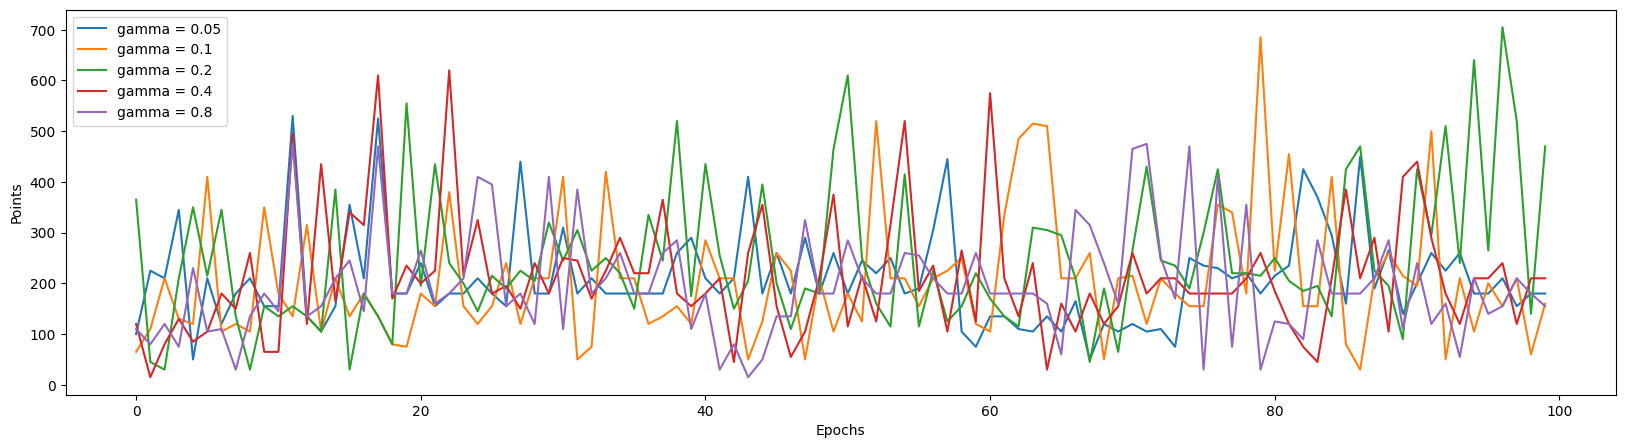

In [44]:
import matplotlib.pyplot as plt
plt.plot(range(len(oh_oh_5)), oh_oh_5, label = "gamma = 0.05")
plt.plot(range(len(oh_oh_5)), oh_1, label = "gamma = 0.1")
plt.plot(range(len(oh_oh_5)), oh_2, label = "gamma = 0.2")
plt.plot(range(len(oh_oh_5)), oh_4, label = "gamma = 0.4")
plt.plot(range(len(oh_oh_5)), oh_8, label = "gamma = 0.8")
plt.xlabel("Epochs")
plt.ylabel("Points")
plt.legend()
plt.show()

In [21]:
frame_stacked_oh_05 = total_rewards1
frame_stacked_oh_1 = [180.0, 210.0, 135.0, 180.0, 50.0, 100.0, 290.0, 225.0, 180.0, 165.0, 180.0, 155.0, 110.0, 155.0, 180.0, 210.0, 135.0, 240.0, 135.0, 380.0, 105.0, 210.0, 180.0, 185.0, 180.0, 210.0, 155.0, 260.0, 380.0, 155.0, 80.0, 330.0, 80.0, 180.0, 285.0, 240.0, 95.0, 105.0, 335.0, 410.0, 60.0, 380.0, 180.0, 355.0, 210.0, 105.0, 180.0, 135.0, 315.0, 180.0, 180.0, 135.0, 410.0, 260.0, 210.0, 380.0, 155.0, 135.0, 155.0, 105.0, 210.0, 260.0, 135.0, 210.0, 210.0, 270.0, 155.0, 105.0, 105.0, 460.0, 540.0, 155.0, 120.0, 155.0, 150.0, 105.0, 130.0, 180.0, 345.0, 180.0, 260.0, 210.0, 210.0, 80.0, 445.0, 180.0, 120.0, 105.0, 105.0, 105.0, 300.0, 50.0, 130.0, 110.0, 210.0, 55.0, 65.0, 385.0, 155.0, 410.0]
frame_stacked_oh_2 = [90.0, 110.0, 135.0, 135.0, 55.0, 405.0, 95.0, 320.0, 155.0, 125.0, 125.0, 55.0, 440.0, 100.0, 40.0, 140.0, 45.0, 45.0, 20.0, 35.0, 60.0, 80.0, 555.0, 45.0, 40.0, 300.0, 80.0, 65.0, 220.0, 165.0, 30.0, 80.0, 175.0, 230.0, 30.0, 525.0, 275.0, 70.0, 65.0, 115.0, 75.0, 25.0, 625.0, 130.0, 80.0, 170.0, 275.0, 220.0, 200.0, 260.0, 20.0, 95.0, 275.0, 105.0, 370.0, 20.0, 40.0, 35.0, 65.0, 395.0, 205.0, 85.0, 30.0, 50.0, 255.0, 35.0, 260.0, 350.0, 55.0, 290.0, 425.0, 45.0, 70.0, 90.0, 120.0, 365.0, 80.0, 115.0, 250.0, 155.0, 355.0, 320.0, 245.0, 190.0, 65.0, 60.0, 250.0, 210.0, 200.0, 50.0, 355.0, 70.0, 115.0, 335.0, 350.0, 135.0, 45.0, 570.0, 30.0, 120.0]
frame_stacked_oh_4 = [240.0, 240.0, 210.0, 105.0, 30.0, 155.0, 105.0, 75.0, 180.0, 210.0, 490.0, 155.0, 210.0, 210.0, 240.0, 180.0, 105.0, 155.0, 105.0, 180.0, 135.0, 155.0, 180.0, 105.0, 155.0, 105.0, 105.0, 105.0, 155.0, 180.0, 155.0, 30.0, 120.0, 75.0, 105.0, 120.0, 105.0, 180.0, 135.0, 50.0, 125.0, 105.0, 160.0, 75.0, 105.0, 105.0, 105.0, 120.0, 75.0, 105.0, 80.0, 50.0, 155.0, 105.0, 275.0, 55.0, 15.0, 155.0, 75.0, 75.0, 50.0, 140.0, 125.0, 145.0, 105.0, 140.0, 50.0, 105.0, 105.0, 135.0, 55.0, 145.0, 115.0, 180.0, 105.0, 210.0, 120.0, 105.0, 120.0, 105.0, 155.0, 105.0, 105.0, 155.0, 135.0, 105.0, 120.0, 105.0, 140.0, 50.0, 135.0, 190.0, 165.0, 135.0, 140.0, 175.0, 180.0, 135.0, 110.0, 30.0]
frame_stacked_oh_8 = [135.0, 110.0, 80.0, 545.0, 155.0, 140.0, 125.0, 130.0, 80.0, 240.0, 90.0, 95.0, 220.0, 145.0, 210.0, 155.0, 275.0, 215.0, 295.0, 295.0, 465.0, 205.0, 300.0, 260.0, 165.0, 160.0, 250.0, 510.0, 155.0, 360.0, 595.0, 195.0, 245.0, 190.0, 295.0, 115.0, 285.0, 255.0, 180.0, 230.0, 335.0, 165.0, 105.0, 220.0, 235.0, 245.0, 205.0, 130.0, 145.0, 325.0, 470.0, 135.0, 260.0, 155.0, 210.0, 345.0, 165.0, 340.0, 230.0, 255.0, 235.0, 355.0, 220.0, 300.0, 175.0, 210.0, 165.0, 625.0, 250.0, 145.0, 185.0, 405.0, 425.0, 220.0, 160.0, 190.0, 105.0, 180.0, 205.0, 190.0, 170.0, 515.0, 255.0, 220.0, 350.0, 225.0, 355.0, 235.0, 155.0, 240.0, 280.0, 450.0, 165.0, 255.0, 335.0, 205.0, 210.0, 305.0, 245.0, 215.0]

In [38]:
from matplotlib.pyplot import figure

figure(figsize=(240, 6), dpi=80)

<Figure size 19200x480 with 0 Axes>

<Figure size 19200x480 with 0 Axes>

In [35]:
%matplotlib inline

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
plt.rcParams['figure.figsize'] = [20, 5]

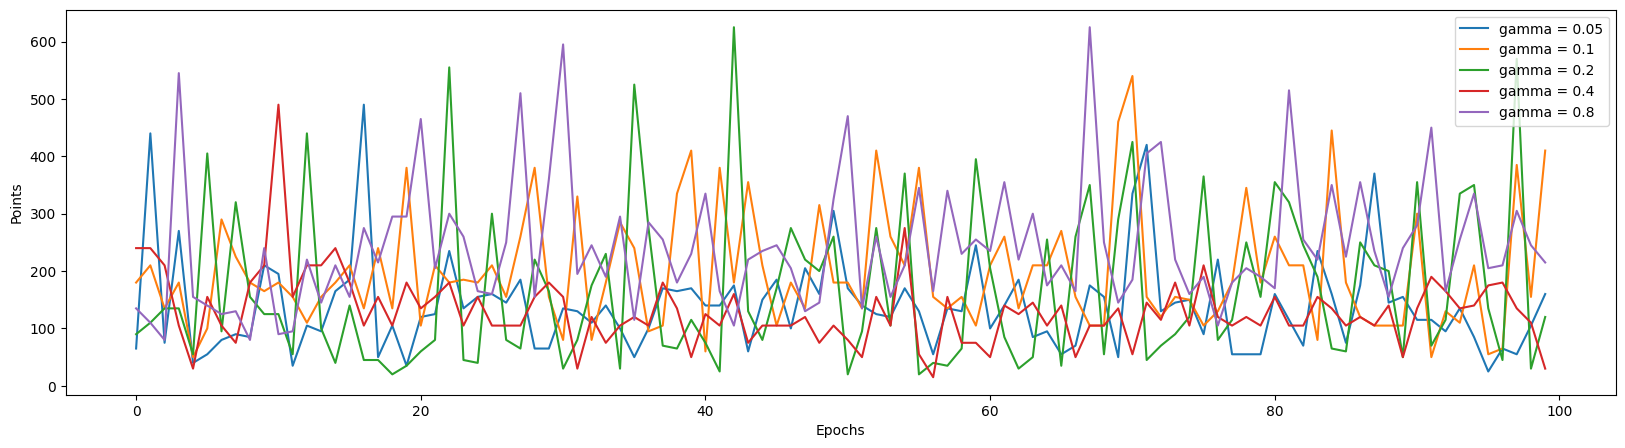

In [43]:
import matplotlib.pyplot as plt
plt.plot(range(len(oh_oh_5)), frame_stacked_oh_05, label = "gamma = 0.05")
plt.plot(range(len(oh_oh_5)), frame_stacked_oh_1, label = "gamma = 0.1")
plt.plot(range(len(oh_oh_5)), frame_stacked_oh_2, label = "gamma = 0.2")
plt.plot(range(len(oh_oh_5)), frame_stacked_oh_4, label = "gamma = 0.4")
plt.plot(range(len(oh_oh_5)), frame_stacked_oh_8, label = "gamma = 0.8")
plt.xlabel("Epochs")
plt.ylabel("Points")
plt.legend()
plt.show()

In [61]:
print(np.mean(oh_4[:25]))

229.0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
